In [1]:
import scanpy as sc

# Load the .h5 file
adata = sc.read_10x_h5('D:/Drug_Response_Prediction/data/17k_Ovarian_Cancer_scFFPE_count_filtered_feature_bc_matrix.h5')

# Print basic information
print(adata)
adata

AnnData object with n_obs × n_vars = 17553 × 18082
    var: 'gene_ids', 'feature_types', 'genome'


C:\Users\Owner\anaconda3\envs\multiomics\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Owner\anaconda3\envs\multiomics\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 17553 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

In [2]:
# Filter out low-quality genes and cells
sc.pp.filter_cells(adata, min_genes=200)  # Keep cells with at least 200 genes
sc.pp.filter_genes(adata, min_cells=3)   # Keep genes expressed in at least 3 cells

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

print("Preprocessing done!")


C:\Users\Owner\anaconda3\envs\multiomics\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Owner\anaconda3\envs\multiomics\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Preprocessing done!


In [3]:
# Compute total counts and add to .obs
adata.obs['total_counts'] = adata.X.sum(axis=1).A1  # Use .A1 to convert sparse matrix to array

# Verify that total_counts is added
print(adata.obs['total_counts'])


AAACAAGCAAAGGTAAACTTTAGG-1    549.225281
AAACAAGCAAATCACGACTTTAGG-1    287.175323
AAACAAGCAACTTGTCACTTTAGG-1    292.253113
AAACAAGCAAGGCCTGACTTTAGG-1    426.376648
AAACAAGCACATTCGTACTTTAGG-1    625.135498
                                 ...    
TTTGGCGGTACCGTTGACTTTAGG-2    333.546417
TTTGGCGGTATTGCGTACTTTAGG-2    356.883575
TTTGGCGGTGATTACCACTTTAGG-2    577.221680
TTTGGCGGTTTCCAAAACTTTAGG-2    280.897278
TTTGTGAGTAAACTGGACTTTAGG-2    195.413376
Name: total_counts, Length: 16956, dtype: float32


C:\Users\Owner\AppData\Local\Temp\ipykernel_4832\3006016208.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['total_counts'] = adata.X.sum(axis=1).A1  # Use .A1 to convert sparse matrix to array


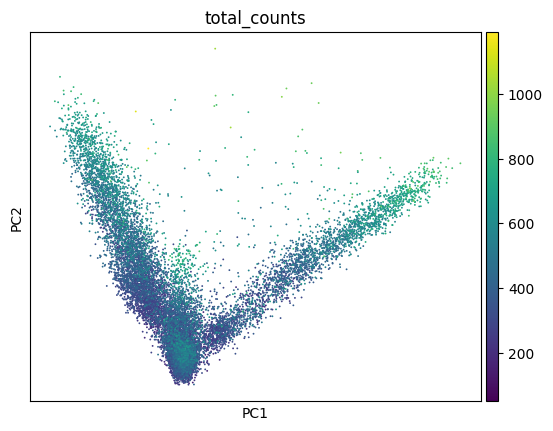

In [4]:
# Perform PCA
sc.tl.pca(adata)
sc.pl.pca(adata, color='total_counts')  # Visualize PCA


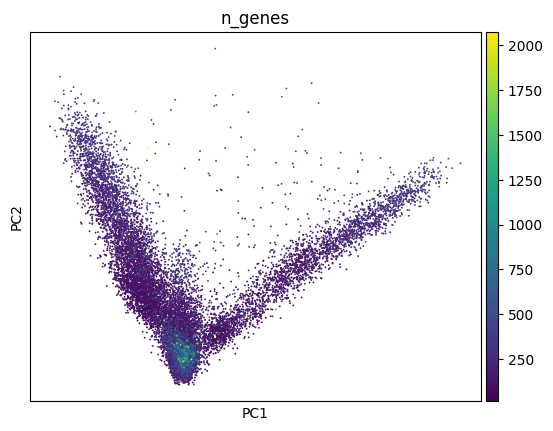

In [5]:
# Compute number of genes per cell (if not already in .obs)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1

# Plot PCA with n_genes as the color
sc.pl.pca(adata, color='n_genes')


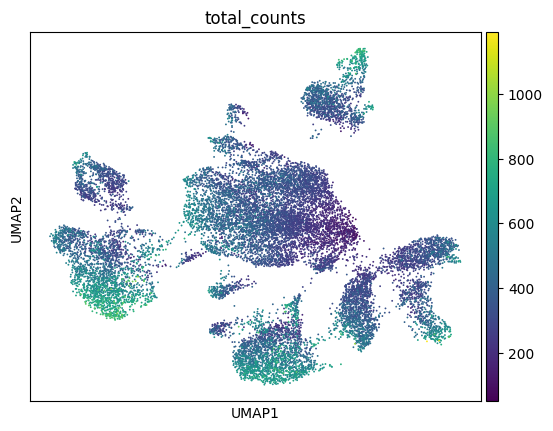

In [6]:
# Construct a neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
# Plot UMAP
sc.pl.umap(adata, color='total_counts')  # Replace 'total_counts' with any valid key in .obs



In [12]:
import scanpy as sc

# Compute neighbors graph (required for clustering)
sc.pp.neighbors(adata)

# Perform Leiden clustering
sc.tl.leiden(adata)

# Check if 'leiden' is now added
print(adata.obs.columns)


C:\Users\Owner\AppData\Local\Temp\ipykernel_4832\2975137298.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Index(['n_genes', 'total_counts', 'leiden'], dtype='object')


In [7]:
adata

AnnData object with n_obs × n_vars = 16956 × 3542
    obs: 'n_genes', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
import torch
import numpy as np

# Convert sparse matrix to dense
dense_matrix = adata.X.toarray()

# Create PyTorch tensor for node features
node_features = torch.tensor(dense_matrix, dtype=torch.float)

# Adjacency matrix (correlation-based)
adjacency_matrix = np.corrcoef(dense_matrix)
edge_index = torch.tensor(np.argwhere(adjacency_matrix > 0.8).T, dtype=torch.long)  # Threshold for edges

print("Node Features Shape:", node_features.shape)
print("Edge Index Shape:", edge_index.shape)


Node Features Shape: torch.Size([16956, 3542])
Edge Index Shape: torch.Size([2, 17188])


In [11]:
print(adata.obs.columns)

Index(['n_genes', 'total_counts'], dtype='object')


In [13]:
labels = adata.obs['leiden'].astype(int)
labels.value_counts()

leiden
0     1974
1     1915
2     1815
3     1585
4     1491
5     1351
6     1207
7     1017
8      996
9      771
10     617
11     608
12     399
13     262
14     224
15     214
16     147
18     129
17     129
19     105
Name: count, dtype: int64

In [15]:
from torch_geometric.data import Data
labels = torch.tensor(adata.obs['leiden'].astype(int).values, dtype=torch.long)

# Create a graph
graph = Data(x=node_features, edge_index=edge_index, y=labels)

print(graph)


Data(x=[16956, 3542], edge_index=[2, 17188], y=[16956])


In [16]:
graph = Data(x=node_features, edge_index=edge_index, y = labels)

print(graph)

Data(x=[16956, 3542], edge_index=[2, 17188], y=[16956])


In [19]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(labels))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
train_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

graph.train_mask = train_mask
graph.test_mask = test_mask

val_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask[val_idx] = True

graph.val_mask = val_mask


In [20]:
graph

Data(x=[16956, 3542], edge_index=[2, 17188], y=[16956], train_mask=[16956], test_mask=[16956], val_mask=[16956])

In [22]:
graph.y = torch.tensor(labels, dtype=torch.long)  # Assuming labels are integers
graph.y

C:\Users\Owner\AppData\Local\Temp\ipykernel_4832\2675123892.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph.y = torch.tensor(labels, dtype=torch.long)  # Assuming labels are integers


tensor([0, 7, 5,  ..., 0, 3, 4])

In [23]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [24]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(input_dim=graph.x.shape[1], hidden_dim=64, output_dim=len(labels.unique())).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

data = graph.to(device)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = out[data.val_mask].max(dim=1)
    val_acc = (pred == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 0, Loss: 3.1453, Val Accuracy: 0.0796
Epoch 1, Loss: 2.3732, Val Accuracy: 0.3903
Epoch 2, Loss: 1.3826, Val Accuracy: 0.6167
Epoch 3, Loss: 1.1810, Val Accuracy: 0.6194
Epoch 4, Loss: 0.7543, Val Accuracy: 0.7494
Epoch 5, Loss: 0.7361, Val Accuracy: 0.7220
Epoch 6, Loss: 0.5953, Val Accuracy: 0.7618
Epoch 7, Loss: 0.4685, Val Accuracy: 0.8252
Epoch 8, Loss: 0.4233, Val Accuracy: 0.8328
Epoch 9, Loss: 0.3712, Val Accuracy: 0.8411
Epoch 10, Loss: 0.3100, Val Accuracy: 0.8597
Epoch 11, Loss: 0.2861, Val Accuracy: 0.8570
Epoch 12, Loss: 0.2745, Val Accuracy: 0.8508
Epoch 13, Loss: 0.2418, Val Accuracy: 0.8591
Epoch 14, Loss: 0.2104, Val Accuracy: 0.8709
Epoch 15, Loss: 0.2028, Val Accuracy: 0.8762
Epoch 16, Loss: 0.1927, Val Accuracy: 0.8756
Epoch 17, Loss: 0.1738, Val Accuracy: 0.8765
Epoch 18, Loss: 0.1568, Val Accuracy: 0.8797
Epoch 19, Loss: 0.1424, Val Accuracy: 0.8779
Epoch 20, Loss: 0.1299, Val Accuracy: 0.8782
Epoch 21, Loss: 0.1184, Val Accuracy: 0.8821
Epoch 22, Loss: 0.10

In [28]:
model.eval()
with torch.no_grad():
    # Forward pass
    out = model(data.x, data.edge_index)

    # Get predictions for test set
    _, pred = out[data.test_mask].max(dim=1)

    # Calculate accuracy
    test_acc = (pred == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8906
